In [290]:
import numpy as np
import pandas as pd

import random 

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptc

from shapely.geometry import Point
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.ops import cascaded_union

import geopandas as gpd

import psycopg2
# from config import config

In [324]:
grid = (64,64)
map_width = grid[0]
map_height = grid[1]

In [325]:
min_lat = -2
max_lat = 13
min_lon = 40
max_lon = 52

eps = 1e-6

In [326]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

In [327]:
wsteps = [round(i,2) for i in list(frange(min_lat-eps,max_lat+eps,(max_lat-min_lat)/map_height))]
hsteps = [round(i,2) for i in list(frange(min_lon-eps,max_lon+eps,(max_lon-min_lon)/map_width))]

In [328]:
rasterdf = pd.DataFrame(columns = ['gridloc','geometry'])
for i in range(0,len(wsteps)-1):
    for j in range(0,len(hsteps)-1):
        x = {}
        w = wsteps
        h = hsteps
        x['gridloc'] = (i,j)
        x['geometry'] = Polygon([(w[i],h[j]),(w[i],h[j+1]),(w[i+1],h[j+1]),(w[i+1],h[j]),(w[i],h[j])])
        rasterdf = rasterdf.append(x,ignore_index=True)

In [329]:
rasterdf

,gridloc,geometry
0,"(0, 0)","POLYGON ((-2 40, -2 40.19, -1.77 40.19, -1.77 ..."
1,"(0, 1)","POLYGON ((-2 40.19, -2 40.37, -1.77 40.37, -1...."
2,"(0, 2)","POLYGON ((-2 40.37, -2 40.56, -1.77 40.56, -1...."
3,"(0, 3)","POLYGON ((-2 40.56, -2 40.75, -1.77 40.75, -1...."
4,"(0, 4)","POLYGON ((-2 40.75, -2 40.94, -1.77 40.94, -1...."
...,...,...
4091,"(63, 59)","POLYGON ((12.77 51.06, 12.77 51.25, 13 51.25, ..."
4092,"(63, 60)","POLYGON ((12.77 51.25, 12.77 51.44, 13 51.44, ..."
4093,"(63, 61)","POLYGON ((12.77 51.44, 12.77 51.62, 13 51.62, ..."
4094,"(63, 62)","POLYGON ((12.77 51.62, 12.77 51.81, 13 51.81, ..."


In [330]:
l = 5
start_1 = 27

start_2 = 68

pollist = list()
for i in range(0,l):
    ctrX = float(np.random.uniform(-2, 13))
    ctrY = float(np.random.uniform(40, 52))
#     aveRadius = float(np.random.uniform(0.001, 0.1))
    aveRadius = 0.5

    verts = generatePolygon(ctrX=ctrX, ctrY=ctrY, 
                            aveRadius=aveRadius, irregularity=0.35, 
                            spikeyness=0.2, numVerts=16)

    pollist.append(Polygon(verts))
    
x = {} 
catarray = range(0,l)
x['value'] = [random.choice(catarray) for i in catarray]
x['geometry'] = pollist
df_pol = pd.DataFrame.from_dict(x)
df_pol.head()

,value,geometry
0,0,"POLYGON ((4.406906653901372 41.55291200690202,..."
1,0,POLYGON ((0.04875553611405814 42.6190320934600...
2,0,POLYGON ((-1.311163936664504 48.84595530252906...
3,4,"POLYGON ((11.42867736931031 41.95444955367385,..."
4,2,"POLYGON ((4.125568317723856 48.25473156578472,..."


In [331]:
import geopandas as gpd
df_som = gpd.read_file("./som_geo_data/som_admbnda_adm2_undp.shp")
df_som = df_som.sort_values(by='admin2Name')

In [332]:
df_som['admin2Name']

44    Adan Yabaal
49        Afgooye
71        Afmadow
62     Baardheere
72      Badhaadhe
         ...     
54     Wanla Weyn
14    Xarardheere
18          Xudun
59          Xudur
4          Zeylac
Name: admin2Name, Length: 74, dtype: object

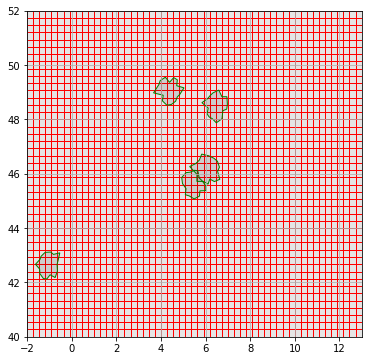

In [298]:
fig, ax = plt.subplots(figsize=(6,6))
fig.canvas.draw() 

ax.grid(True)
ax.axis([-2, 13, 40, 52])

for pol in rasterdf['geometry']:
    polpc = ptc.Polygon(np.array(pol.exterior), fc=[0,0,0,0.1], edgecolor='red', lw=1)
    ax.add_patch(polpc)

for pol in df_pol['geometry']:
    polpc = ptc.Polygon(np.array(pol.exterior), fc=[0,0,0,0.1], edgecolor='green', lw=1)
    ax.add_patch(polpc)

In [333]:
dx = np.zeros([64,64])

for i in range(0,df_pol.shape[0]):
    x = []
    ar = [df_pol.loc[i,'geometry'].intersects(pixel) for pixel in rasterdf['geometry']]
    x = [df_pol.loc[i,'geometry'].intersection(pixel).area/pixel.area for pixel in rasterdf['geometry']]
    x = np.dot(x,df_pol.loc[i,'value']/np.sum(ar))
    dx += np.array(x).reshape(64,64)

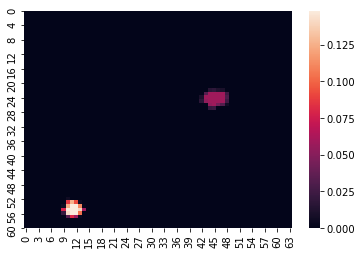

In [334]:
sns.heatmap(dx)